# Week 02 – Glassbox Models (part 1) – Solutions

In this notebook we'll be applying different glassbox models to the same dataset and compare their performance in terms of accuracy and f1-score and their interpretability.

#### Step 1: Navigate to this week's directory 
```
cd <path_to_week_2_material>
```

#### Step 2: Create and Activate a virtual environment (Python 3.9)
**MacOS**
```
python3.9 -m venv part1_venv
source part1_venv/bin/activate
```

**Windows (cmd)**
```
python3.9 -m venv part1_venv
part1_venv\Scripts\activate
```

#### Step 3: Install required packages
First, install `ipykernel` to integrate your virtual environment with Jupyter.
```
pip install ipykernel
python -m ipykernel install --user --name=part1_venv
```

Next, install all necessary dependencies from the requirements.txt file.
```
pip install -r requirements.txt
```

#### Step 4: Install `pydl8.5-lbguess`
```
git clone https://github.com/ubc-systopia/pydl8.5-lbguess.git
cd pydl8.5-lbguess
python3 setup.py install
```

**import packages**

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score
import os
import sys
import matplotlib.pyplot as plt

# Load the dataset

We are using the [Titanic dataset](https://www.kaggle.com/c/titanic/overview), which holds data about passangers of the Titanic and whether they survived or not. Passengers are described by 7 features. The response variable is binary (0 – died; 1 - survived).

Make sure to save the dataset in the parent directory or adjust the file path below.

We are directly loading the pre-processed data sets. For some algorithms, we require the data to be in binary form. Hence, we have two versions of X: `X_train` and `X_test`, with continous features and one-hot encoded categorical features, and `X_train_bin` and `X_test_bin`, where all features have been one-hot encoded. For this, continuous features were first transformed into categories. Check the code in `./01_intro/titanic_data_prep.ipynb` for more details on pre-processing.

In [2]:
# X_train 
X_train = pd.read_csv('../datasets/titanic/encoded_titanic_X_train.csv')
X_train_bin = pd.read_csv('../datasets/titanic/bin_titanic_X_train.csv')

# X_test
X_test = pd.read_csv('../datasets/titanic/encoded_titanic_X_test.csv')
X_test_bin = pd.read_csv('../datasets/titanic/bin_titanic_X_test.csv')

# y_train and y_test
y_train = pd.read_csv('../datasets/titanic/titanic_y_train.csv')
y_test = pd.read_csv('../datasets/titanic/titanic_y_test.csv')

# take a look at the data
X_train.head()

,Age,SibSp,Parch,Fare,Sex_1,Embarked_1,Embarked_2,Pclass_1,Pclass_2
0,29.699118,0,0,7.6292,0,1,0,0,1
1,29.699118,0,0,8.0500,1,0,1,0,1
2,29.699118,0,0,7.7500,0,1,0,0,1
3,51.000000,1,0,77.9583,0,0,1,0,0
4,21.000000,0,0,7.7333,1,1,0,0,1


## About the dataset

- `Age` – age of a person in years (int)
- `SibSp` – the number of siblings or spouse of a person **onboard** (int)
- `Parch` – the number of parents or children of a person **onbard** (int)
- `Fare` – ticket price (float)
- `Sex` – sex of a person (categorical/binary)
- `Embarked` – location where the traveler mounted from. There are three possible values — Southampton, Cherbourg, and Queenstown (categorical)
- `Pclass` – passenger division into class 1, 2, and 3 (categorical)
- `Survived` – whether person survived the sinking of the ship (binary). Less than 40% survived. This is the **outcome** to predict. 


From the original dataset and from preprocessing the data, we know the following about the **categorical features**:

- `Sex` has two values `['female','male']`, which were encoded `[0,1]`, respectively. Then, after applying one-hot encoding, we have `Sex_1` which indicates `male` if 1, `female` otherwise.
- `Embarked` has three values `['C', 'Q', 'S']`, which were encoded `[0,1,2]`, respectively. Hence,
    - `Embarked_1 = 1` indicates `Q` 
    - `Embarked_2 = 1` indicates `S`
    - `Embarked_1 = 0` and `Embarked_2 = 0` indicated `C`
- `Pclass` has three values `[1,2,3]`, which were encoded `[0,1,2]`, respectively. Hence, after encoding, we have:
    - `Pclass_1 = 1` indicates `2`
    - `Pclass_2 = 1` indicates `3`
    - `Pclass_1 = 0` and `Pclass_2 = 0` indicates `1`

In [3]:
d = {
    'target': 'Survived',
    'numerical':['Age', 'SibSp', 'Parch', 'Fare'],
    'categorical':['Sex', 'Embarked', 'Pclass']
}

# save feature names
feature_names = X_train.columns
target_names = list(y_train[d['target']].unique())

# create a dataframe to save y values in 
y_results = pd.DataFrame()
y_results['y_test'] = y_test

---
---

# 1. Linear Models – Logistic Regression

The most commonly used package to run a logistic or linear regression model is `scikit-learn`. However, the package `interpret` has a wrapper for the logistic regression model fit by `scikit-learn`, with the added value of visualizing the model and for purposes of (global and local) interpretation. Hence, we will be using `interpret` to fit the logistic regression model.

In [4]:
# from sklearn.linear_model import LogisticRegression
from interpret.glassbox import LogisticRegression
from interpret import show

In [5]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
y_results['lr_pred'] = lr.predict(X_test)

## inspect performance

In [6]:
# Confusion matrix
cm = pd.crosstab(y_results['y_test'], y_results['lr_pred'])
print ("Confusion matrix : \n", cm)

print('\nAccuracy  = %.4f' % accuracy_score(y_results['y_test'], y_results['lr_pred']))
print('F1 score  = %.4f' % f1_score(y_results['y_test'], y_results['lr_pred']))

Confusion matrix : 
 lr_pred   0   1
y_test         
0        99  11
1        25  44

Accuracy  = 0.7989
F1 score  = 0.7097


### Questions

**Q 1.1 – Evaluate the model performance.**

The accuracy is relatively good, with 79.89% on the test set. This means that off all samples in the test set, regardless of their true class, 79.89% received the correct prediction. The F1-score provides a more nuanced measure for overall classification performance, especially for imbalanced data. The F1-score is 70.97%, which is not particularly high but still quite good.

## model interpretation
---
### GLOBAL

In [7]:
lr_global_expl = lr.explain_global()
show(lr_global_expl)

<!-- http://127.0.0.1:7745/140319986081904/ -->

We can also inspect the feature contribution of each (or the x most important) feature(s) and/or interactions of features:

In [8]:
expl_dict = lr_global_expl.data()

# combine names and scores into tuples
name_score_pairs = list(zip(expl_dict['names'], expl_dict['scores']))

# sort by scores in descending order
sorted_name_score_pairs = sorted(name_score_pairs, key=lambda x: abs(x[1]), reverse=True)

# print the sorted names, scores, and ranks
for rank, (name, score) in enumerate(sorted_name_score_pairs, start=1):
    print(f'{rank}. {name}: {round(score,4)}')

1. Sex_1: -2.5863
2. Pclass_2: -1.9532
3. Pclass_1: -0.686
4. SibSp: -0.3523
5. Embarked_2: -0.2366
6. Embarked_1: 0.0994
7. Parch: -0.0703
8. Age: -0.0377
9. Fare: 0.0042


### Questions

**Q 1.2 – Explain what is shown in the summary plot.**

The summary plot of the logistic regression model is simply a visualization of the intercept and coefficients in the model. As we are dealing with logistic regression, the interpretation is a bit less straight forward (than with linear regression). Specifically, the coefficient represents the change in the log-odds with a one-unit increase in the respective feature, while keeping the other features fixed.

The logistic function is: $p = \frac{1}{1+e^{-(b_0+b_1x_1+b_2x_2+...+b_nx_n)}}$

Odds are defined as the ratio of probability of success vs probability of failure: 

$\texttt{odds ratio} = \frac{p}{1-p}$

$\texttt{odds ratio} = \frac{\frac{1}{1+e^{-(b_0+b_1x_1+b_2x_2+...+b_nx_n)}}}{1-\frac{1}{1+e^{-(b_0+b_1x_1+b_2x_2+...+b_nx_n)}}}$

$\texttt{odds ratio} = e^{(b_0+b_1x_1+b_2x_2+...+b_nx_n)}$

Take the natural logarithm: 
$log(\frac{p}{1-p}) = b_0+b_1x_1+b_2x_2+...+b_nx_n$

Hence, the coefficient represents the change in log-odds with a one-unit increase in the respective feature. 

The most influential variable in our model is to be `Sex_1`, with a coefficient of -2.5863. Hence, being male (`Sex_1 = 1`) reduces the log-odds for survival by -2.5862. In other words, the odds ratio of survival change by a factor of $e^{(-2.5862)}$, which is 0.0753. So the odds ratio changes by a factor of 0.0753, i.e. men are _less_ likely to survive (because the factor is below 1).

---
### LOCAL

In [9]:
show(lr.explain_local(X_test, y_test))

<!-- http://127.0.0.1:7745/140319986030144/ -->

### Questions

**Q 1.3 – Take a look at the local explanation for sample with index 2 of the test set. How do you explain that `Age` seems to be much more influential in the prediction for this instance, while it does receives almost no importance in the summary plot?**

This is due to the fact that in the summary the size of the bars corresponds to the absolute value of the coefficient, however when making the prediction the coefficients are multiplied with the feature values. We have not standardized the data, and hence some features can take on much larger values, which, when multiplied with the (perhaps small) coefficient, can still lead to a large change in the prediction.

---
---

# 2. Generalized Additive Models (GAM)

In [10]:
import scipy.stats as ss
from pygam import LogisticGAM, s, f, l, te

If you have a lot of features in the dataset, you may only want to pick some of the features to include in the model. For example, for each feature, we can check whether there is a significant correlation with the dependent variable. For categorical features, we use Chi-square; for numerical features we use Spearman's rank correlation. Then, we could select those where the associated p-value is below 0.05. However, here we will include all variables in the model.

Typically, we use factor terms `f()` for categorical variables and spline terms `s()` for numerical variables. We can use linear terms `l()` for numerical variables with a linear relationship to the response variable. Lastly, we could also incluse interaction terms `te()` between two features.

In [11]:
gam = LogisticGAM(s(0) + s(1) + s(2) + s(3) + f(4) + f(5) + f(6) + f(7) + f(8))
gam.fit(X_train, y_train)

y_results['gam_pred'] = gam.predict(X_test)*1 # *1 to concert to 0's and 1's (from True and False)

## inspect performance

In [12]:
# Confusion matrix
cm = pd.crosstab(y_results['y_test'], y_results['gam_pred'])
print ("Confusion matrix : \n", cm)

print('\nAccuracy  = %.4f' % accuracy_score(y_results['y_test'], y_results['gam_pred']))
print('F1 score  = %.4f' % f1_score(y_results['y_test'], y_results['gam_pred']))

Confusion matrix : 
 gam_pred   0   1
y_test          
0         95  15
1         22  47

Accuracy  = 0.7933
F1 score  = 0.7176


## model interpretation
---
### GLOBAL

In [13]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     26.2537
Link Function:                        LogitLink Log Likelihood:                                   -289.182
Number of Samples:                          712 AIC:                                              630.8712
                                                AICc:                                             633.1236
                                                UBRE:                                               2.9156
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3899
Feature Function                  Lam

---
---
# 3. Explainable Boosting Machine (EBM)

Explainable Boosting Machine (EBM) has been implemented by interpretML. See the documentation here: https://interpret.ml/docs/python/api/ExplainableBoostingClassifier.html

In [14]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

In [15]:
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)
y_results['ebm_pred'] = ebm.predict(X_test) #save predicted values

## inspect performance

In [16]:
# Confusion matrix
cm = pd.crosstab(y_results['y_test'], y_results['ebm_pred'])
print ("Confusion matrix : \n", cm)

print('\nAccuracy  = %.4f' % accuracy_score(y_results['y_test'], y_results['ebm_pred']))
print('F1 score  = %.4f' % f1_score(y_results['y_test'], y_results['ebm_pred']))

Confusion matrix : 
 ebm_pred   0   1
y_test          
0         98  12
1         25  44

Accuracy  = 0.7933
F1 score  = 0.7040


### Questions

**Q 3.1 – Evaluate the performance of this model by taking into account the performance scores.**

The performance of this model on the test data is okay, but actually not that good especially compared to the other models. The F1-score falls below 70%.

## model interpretation

---
### GLOBAL

In the display below, you can see the all feature importances in a summary plot and you can select each feature separately and inspect it's impact on the predictions more closely. 

In [17]:
ebm_global_expl = ebm.explain_global()
show(ebm_global_expl)

<!-- http://127.0.0.1:7745/140319401601344/ -->

We can also inspect the feature contribution of each (or the x most important) feature(s) and/or interactions of features:

In [18]:
expl_dict = ebm_global_expl.data()

# combine names and scores into tuples
name_score_pairs = list(zip(expl_dict['names'], expl_dict['scores']))

# sort by scores in descending order
sorted_name_score_pairs = sorted(name_score_pairs, key=lambda x: x[1], reverse=True)

# print the sorted names, scores, and ranks
for rank, (name, score) in enumerate(sorted_name_score_pairs[:10], start=1):
    print(f'{rank}. {name}: {round(score,4)}')

1. Sex_1: 1.0563
2. Pclass_2: 0.3945
3. Fare: 0.3883
4. Age & Fare: 0.2059
5. Age: 0.1994
6. SibSp: 0.1919
7. Sex_1 & Pclass_2: 0.179
8. Fare & Sex_1: 0.1352
9. Embarked_2: 0.1211
10. Sex_1 & Pclass_1: 0.1102


### Questions

**Q 3.2 – Explain how the feature importances in the summary plot are obtained.**

The contributions of each feature to the predictions for the samples in the train data are averaged. For example, for `Sex_1`, we have 251 samples where this feature contributes 1.498197 towards the overall prediction and 461 samples where the contibution of this feature is -0.8157212. To get the global feature importance, we simply take the average: $(251\times1.498197 + 461\times(-0.8157212))/712 = 1.0563$

**Q 3.3 – How can we interpret the error bars in the plots of individual features?**

These are estimates of the model’s uncertainty (standard deviation) within certain regions of the feature. The more variance there is, the greater the impact of small changes in the training data.
(see [this FAQ page](https://interpret.ml/docs/faq.html) for more info)


**Q 3.4 – Provide a full interpretation of the importance of feature `Age` using these plots.**

According to the summary plot, `Age` receives the 5th highest overall feature importance, with a score of 0.1994. Looking at the individual plot for this feature, we see that the highest density is around age 25-31, where the impact of this feature on the target is nearly zero. Below age 18, the impact on the target score is positive with an increasing trend into that direction. Above age 37, there is a negative impact, indicating that older people are less likely to survive. At both ends of the distribution (young and old) the density is very low, so we have little information here which is also reflected in the error bars.

---
### LOCAL

In [19]:
show(ebm.explain_local(X_test, y_test))

<!-- http://127.0.0.1:7745/140319401424640/ -->

### Questions

**Q 3.5 – Take a look at the local explanation for sample with index 9 of the test set. How would you interpret this explanation?**

The true class for this data point is 1, which means this person survived the titanic, however the model (mis)predicts class 0 with a probability of 0.87. The intercept of the model is -0.60, and most variables have a 'negative' impact on the prediction, so decreasing the score. The feature with the highest negative impact is `Sex_1`, i.e. being male, followed by `Pclass_2`, i.e. whether someone travelled 3rd class (the lowest class). The person travelled alone, without any siblings (`SibSp`), which had a positive impact on the score. The interaction of `Age` and `Fare` also had a positive impact on the prediction.

---
---
# 4. Decision Trees


## 4.1 Fast Sparse Decision Trees

This is a developing field and many people publish their code on Github. We will be using the code from this Github repo: https://github.com/ubc-systopia/pydl8.5-lbguess, which provides the code for the paper by [McTavish et al. (2022)](https://arxiv.org/abs/2112.00798) on Fast Sparse Decision Trees.

Note: This algorithm works with **binary** input data only. 

⚠️ This code requires `scikit-learn==1.1.2`.

In [20]:
sys.path.insert(1, os.path.dirname(os.getcwd())+'/pydl8.5-lbguess')
from dl85 import DL85Classifier
import fsdt_helpers 

In [21]:
fsdt = DL85Classifier(time_limit=300, desc=True, max_depth=3)
fsdt.fit(X_train_bin, y_train)
y_results['fsdt_pred'] = fsdt.predict(X_test_bin) #save predicted values

TESTING STUFFDL8.5 fitting: Solution found



## inspect performance

In [22]:
# Confusion matrix
cm = pd.crosstab(y_results['y_test'], y_results['fsdt_pred'])
print ("Confusion matrix : \n", cm)

print('\nAccuracy  = %.4f' % accuracy_score(y_results['y_test'], y_results['fsdt_pred']))
print('F1 score  = %.4f' % f1_score(y_results['y_test'], y_results['fsdt_pred']))

Confusion matrix : 
 fsdt_pred    0   1
y_test            
0          106   4
1           29  40

Accuracy  = 0.8156
F1 score  = 0.7080


### Questions

**Q 4.1.1 – Evaluate the performance of this model by taking into account the performance scores.**

This model performs slightly better than the logistic regression model, with an accuracy of 81.56% on the test set. This means that off all samples in the test set, regardless of their true class, 81.56% received the correct prediction. The F1-score provides a more nuanced measure for overall classification performance, especially for imbalanced data. The F1-score is 70.80%, which is not particularly high but still quite good. This score is almost the same as for the logistic regression model.

## model interpretation

We wrote some helper functions to extract the number of leaves (aka rules), the average rule length in the tree, and the average rule length per sample.

---
### GLOBAL

In [23]:
print('Number of rules = %.0f' % fsdt_helpers.get_num_leaves(fsdt.tree_))
print('Average rule length = %.2f' % fsdt_helpers.get_avg_rule_length(fsdt.tree_))

Number of rules = 8
Average rule length = 3.00


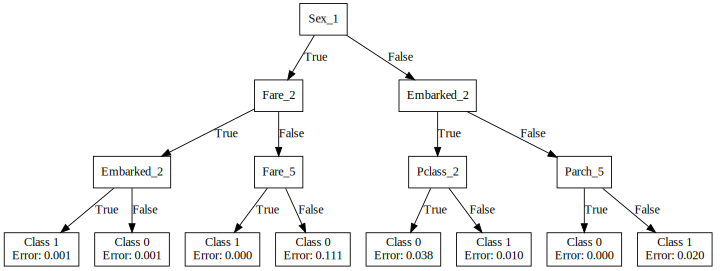

In [24]:
# plot tree
fsdt_helpers.display_tree(tree = fsdt.tree_, n = len(X_train_bin), feature_names = X_train_bin.columns)

### Questions

**Q 4.1.2 – Discuss global interpretability of the resulting tree.**

The tree consists of a total of 8 rules, each of which has a length of 3. The root node uses the feature `Sex_1` as a splitting criterion, which hence seems to be the most important feature in making the prediction. With a total of 8 rules that are all relatively short, this tree is pretty transparent and readily comprehensible.

---
### LOCAL

In [25]:
print('Average number of rules used per sample = %.2f' % 1.00)
print('Average rule length per sample = %.2f' % fsdt_helpers.get_avg_rule_length_per_sample(fsdt.tree_,np.array(X_test_bin)))

Average number of rules used per sample = 1.00
Average rule length per sample = 3.00


In [26]:
X_test_bin.iloc[2,:]

Pclass_1      0
Pclass_2      1
Sex_1         0
Age_2         0
Age_3         1
Age_4         0
Age_5         0
SibSp_2       0
SibSp_3       0
SibSp_4       0
SibSp_5       0
Parch_2       0
Parch_3       0
Parch_4       0
Parch_5       1
Fare_2        0
Fare_3        0
Fare_4        0
Fare_5        0
Embarked_1    0
Embarked_2    1
Name: 2, dtype: int64

### Questions

**Q 4.1.3 – Explain how you would make the prediction for sample with index 2 of the test set.**

We start at the root node and check whether `Sex_1` is 0 or 1 for this sample. `Sex_1 = 1` (i.e. male) for the sample, and hence we follow the path to the right. The next decision node splits feature `Embarked_2`, which is 1 for this sample, meaning this passenger embarked in Southhampton. Hence, we follow the path to the left (true). The last decision node evaluates `Pclass_2`, which is also 1 for the sample we're looking at, which means we follow the path to the left and end up in a leaf node that assigns the sample to class 0, which indicates that this person is predicted to not survive.

## 4.2 CART

Let's compare this to the most popular algorithm to grow a decision tree, which is called CART and is implemented in `scikit-learn`. 

To be able to **directly** compare both trees, we will again use the **binary** datasets `X_train_bin` and `X_test_bin` to train and test the model, respectively, even though CART can handle continous data.

Feel free to train CART on the continous data `X_train` and inspect the results as well.

In [27]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [28]:
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_train_bin, y_train)
y_results['tree_pred'] = tree.predict(X_test_bin) #save predicted values

## inspect performance

In [29]:
# Confusion matrix
cm = pd.crosstab(y_results['y_test'], y_results['tree_pred'])
print ("Confusion matrix : \n", cm)

print('\nAccuracy  = %.4f' % accuracy_score(y_results['y_test'], y_results['tree_pred']))
print('F1 score  = %.4f' % f1_score(y_results['y_test'], y_results['tree_pred']))

Confusion matrix : 
 tree_pred    0   1
y_test            
0          107   3
1           36  33

Accuracy  = 0.7821
F1 score  = 0.6286


### Questions

**Q 4.2.1 – Evaluate the performance of this model by taking into account the performance scores.**

The CART decision tree performs a bit worse, especially looking at the F1-score, which is only 62.86%. In terms of accuracy, the tree performs only a bit worse than the fast sparse decision tree.

## model interpretation 
---
### GLOBAL

Number of rules = 8
Average rule length = 3.00


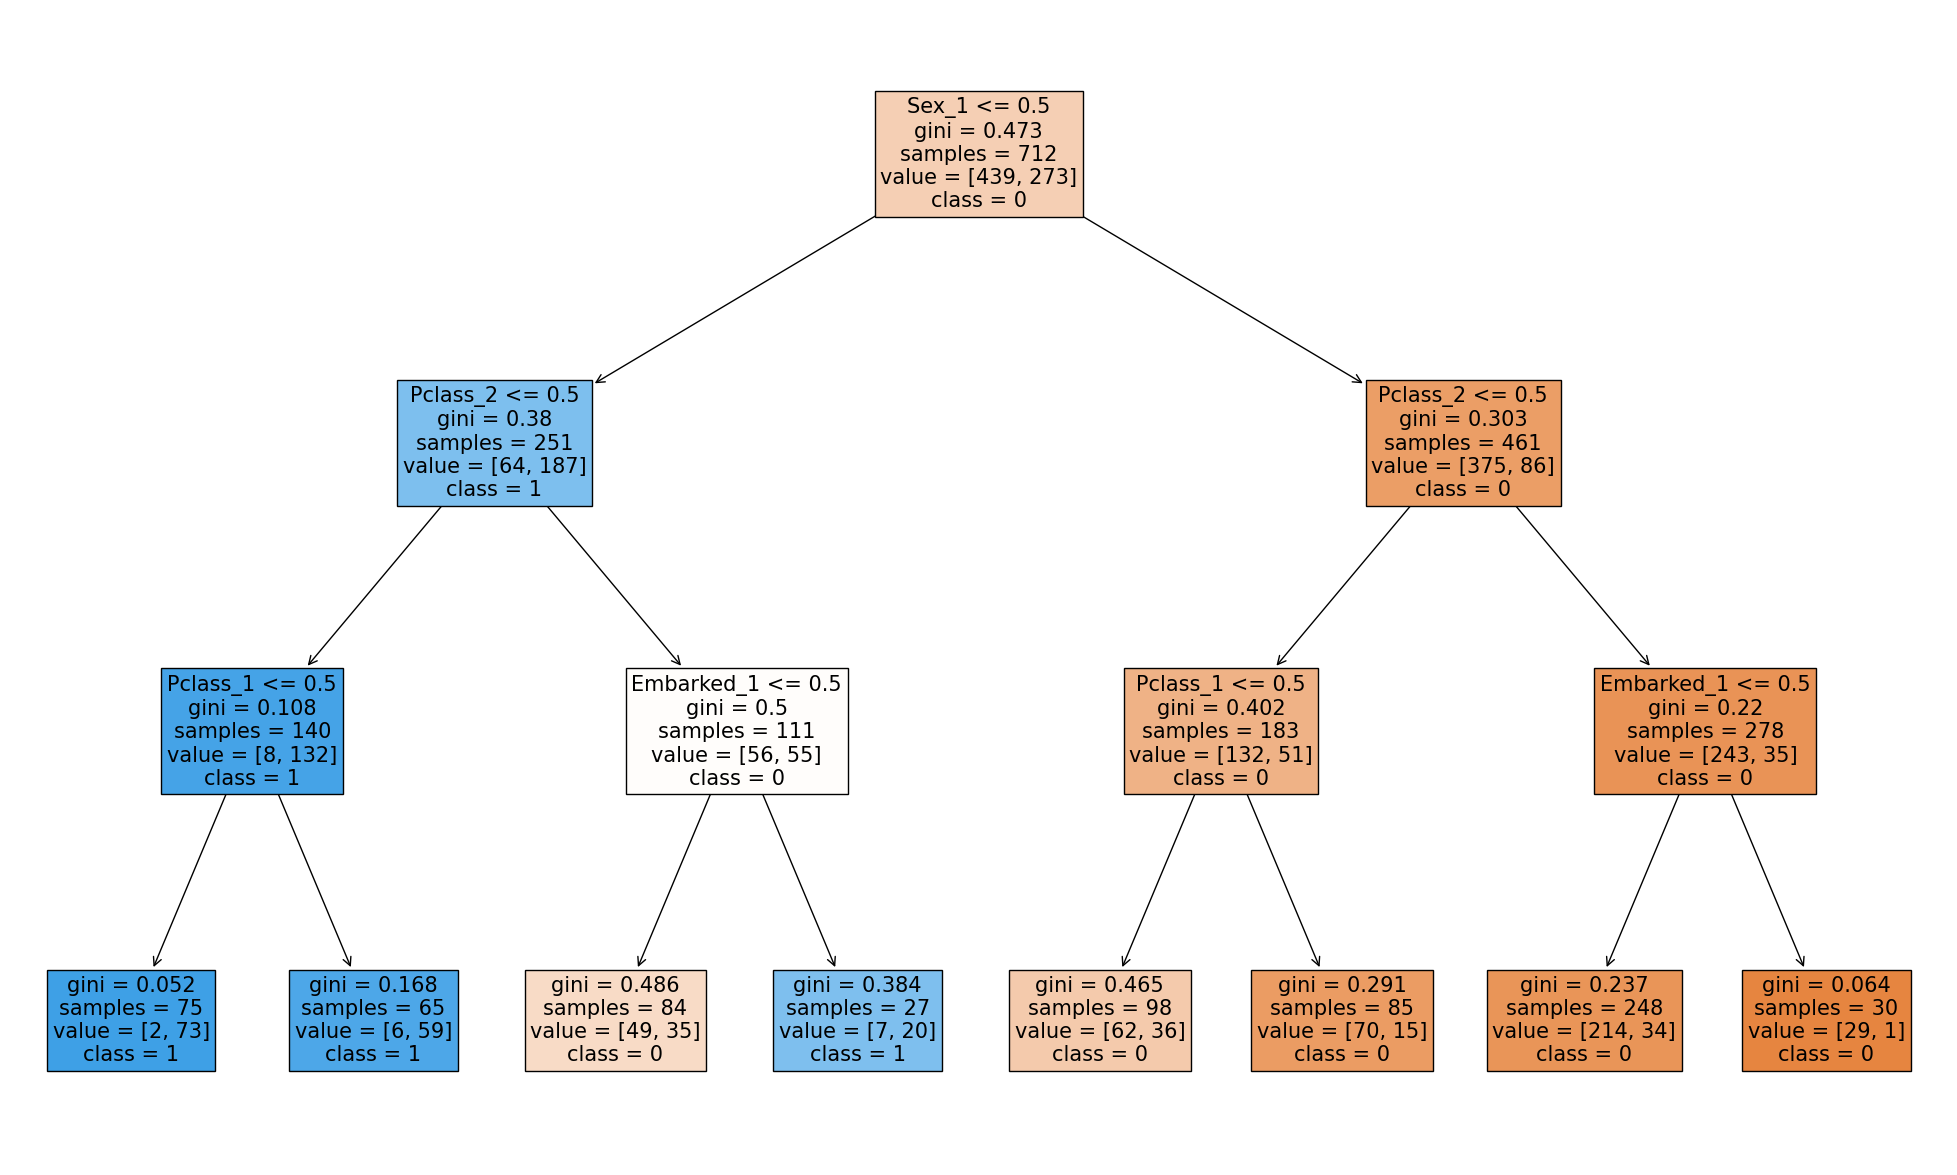

In [30]:
fig = plt.figure(figsize=(25,15))
_ = plot_tree(tree, feature_names=X_train_bin.columns, class_names=['{:.0f}'.format(x) for x in target_names], filled=True, fontsize=15)

print('Number of rules = %.0f' % tree.get_n_leaves())
print('Average rule length = %.2f' % tree.get_depth())

### Questions

**Q 4.2.2 – Which feature is, based on this tree, the most important variable to predict survival?**

Here as well, the most important feature in predicting survival of the titanic seems to be `Sex_1`.

--- 
### LOCAL

### Questions

**Q 4.2.3 – Explain how you would make the prediction for sample with index 2 of the test set.**

First of all, in `sklearn`'s decision tree, if a sample **satisfies** the condition it goes to the LEFT, otherwise to the RIGHT. We start at the root node and check whether `Sex_1 <= 0.5` for this sample. `Sex_1 = 1` for the sample, and hence we follow the path to the right. The next decision node splits feature `Pclass_2`, which is 1 for this sample. Hence, we follow the path to the right again. The last decision node evaluates `Embarked_1`, which is 0 for the sample we're looking at, which means we follow the path to the left and end up in a leaf node that assigns the sample to class 0.

---
---

# 5. Decision Rules

## 5.1 Decision Lists

We will use another algorithm that generates rules and is implemented in `interpret`. See the documentation here: https://interpret.ml/docs/dr.html. 

The package uses a wrapper for the algorithm skope-rules from [Gardin et al. (2017)](https://zenodo.org/records/4316671), which is a weighted combination of rules extracted from a tree ensemble using L1-regularized optimization over the weights.

Typically, in a decision list, the prediction is made using only the first rule in the list that applies to a sample.

In [31]:
from interpret.glassbox import DecisionListClassifier

In [32]:
dl = DecisionListClassifier(random_state=21, max_depth=3)
dl.fit(X_train, y_train)
y_results['dl_pred'] = dl.predict(X_test)

## inspect performance

In [33]:
# Confusion matrix
cm = pd.crosstab(y_results['y_test'], y_results['dl_pred'])
print ("Confusion matrix : \n", cm)

print('\nAccuracy  = %.4f' % accuracy_score(y_results['y_test'], y_results['dl_pred']))
print('F1 score  = %.4f' % f1_score(y_results['y_test'], y_results['dl_pred']))

Confusion matrix : 
 dl_pred   0   1
y_test         
0        95  15
1        21  48

Accuracy  = 0.7989
F1 score  = 0.7273


### Questions

**Q 5.1.1 – Evaluate the model performance.**

Again, the performance is quite similar to that of the other models. The F1-score is pretty good, exceeding those of the other models except for RUG.n Accuracy is slightly worse when compared to most of the other models.

## model interpretation
---
### GLOBAL

In [34]:
dl_global_expl = dl.explain_global()
expl_dict = dl_global_expl.data()

In [35]:
print('Number of rules = %.0f' % (len(dl.rules_)-1))
print('Average rule length = %.2f' % np.mean([r.count('and') for r in expl_dict['rule'][:-1]]))

Number of rules = 21
Average rule length = 2.00


In [36]:
show(dl_global_expl)

<!-- http://127.0.0.1:7745/140319689359168/ -->

### Questions

**Q 5.1.2 – Evaluate the global interpretability of the model.**

The model returns 21 rules, with an average length of 2.00. We can use the summary 'plot' to see all rules, and to select rules using specific features.

---
### LOCAL

In [37]:
show(dl.explain_local(X_test, y_test))

<!-- http://127.0.0.1:7745/140319689357296/ -->

### Questions

**Q 5.2.3 – Take a look at the local explanation for the sample with index 2 of the test set. Explain how the prediction is made.**

It says 'No Rules Triggered', which means that actually none of the 21 rules apply to the sample, or in other words the sample does not satisfy any of the rules. In this case, the class that will be assigned to the sample is the majority class in the training data, which is class 0.